In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
import bq
import time

In [32]:
cellsize = .1
one_over_cellsize = 10
if cellsize < 1:
    num_lons = 360*one_over_cellsize
    num_lats = 180 *one_over_cellsize
else:
    num_lons = 360/cellsize
    num_lats = 180/cellsize

In [33]:
def get_area(lat):
    lat_degree = 69 # miles
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0        
    # phi = 90 - latitude
    phi = (lat+cellsize/2.)*degrees_to_radians #plus half a cell size to get the middle
    lon_degree = math.cos(phi)*lat_degree 
    # return 69*69*2.6
    return  lat_degree*lon_degree* 2.58999 # miles to square km

In [34]:
client = bq.Client.Get()
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [35]:
# query to get the density of vessels
vessel_query = []

for i in range(4):
    q = '''
    SELECT 
    integer(lat*'''+str(one_over_cellsize)+''') lat_bin,
    integer(lon*'''+str(one_over_cellsize)+''') lon_bin,
    sum(1/positions) vessels
    FROM [scratch_david_gapanalysis.orbcomm_2015_noduplicates_st_stats]
    where 
      (lat>-48 or positions>10) // get rid of noise in southern ocean
      and mmsi != 220364000 //this one is bad
      and mmsi not in(412437961,412437962,412420502,412420503,412420576,412420574,412420789,412420871,
      900025357,900025393,413322650,414203586,412211196,412440255,412440256,412440257,412440258,412440259,
      412440261,150200162,412440077,412440078,412420805,412420421,412440377,412425706,412447093) // these 
      // are bad ones 
      and max_lat - min_lat <5
      AND (max_lon - min_lon < 10 // This lon filter cuts out 2.7 percent of the data 
        OR first_lon > 170
        OR first_lon < -170)
      and lat > -90 and lat < 90 and lat != 0 
      //divide into 4 parts because a single query is too big for this api
      and lon > '''+ str(i*90-180) + ''' and lon < '''+ str(i*90-90)+'''
      AND mmsi IN (select mmsi from
    [scratch_david_gapanalysis.good_mmsi_2015_1000pings])
    //and tagblock_type = 'terrestrial'
    group by lat_bin, lon_bin
    '''
    vessel_query += Query(q)

Waiting on bqjob_r2fc316ce9b546091_000001533cd8a2f3_14 ... (48s) Current status: DONE   
Query time: 117.368466854 seconds.
Waiting on bqjob_r6b9eb8aa52541486_000001533cda6d7d_15 ... (48s) Current status: DONE   
Query time: 119.762308121 seconds.
Waiting on bqjob_r667089a37089ce50_000001533cdc4166_16 ... (48s) Current status: DONE   
Query time: 113.604336023 seconds.
Waiting on bqjob_r728ba43a0d195788_000001533cddfd42_17 ... (65s) Current status: DONE   
Query time: 135.57118392 seconds.


In [36]:
import cPickle # save the query results for later
cPickle.dump(vessel_query, open('../../data/density/2015_all_vessel_density.p', 'wb')) 

In [37]:
vessel_query = cPickle.load(open('../../data/density/2015_all_vessel_density.p', 'rb'))

In [38]:
vessel_days = np.zeros(shape=(num_lats,num_lons))

for row in vessel_query:
    lat = int(row[0])
    lon = int(row[1])
    if lat<90*one_over_cellsize and lat>-90*one_over_cellsize and lon>-180*one_over_cellsize and lon<180*one_over_cellsize:
        lat_index = lat+90*one_over_cellsize
        lon_index = lon+180*one_over_cellsize
        days = float(row[2])
        area = get_area(lat*float(cellsize)) # approximate area of 1 by 1 degree at a given lat
        vessel_days[lat_index][lon_index] = days / (365.* area*cellsize*cellsize)*100 #vessels per day per 100 square km

In [39]:
vessel_days.dump((open('../../data/density/density2015_1000pings.npy', 'wb')))

In [40]:
vessel_days = np.load('../../data/density/density2015_1000pings.npy')

In [41]:
for i in range(one_over_cellsize*360):
    vessel_days[one_over_cellsize*90][i]=(vessel_days[one_over_cellsize*90+1][i]+vessel_days[one_over_cellsize*90-1][i])/2.
    
for i in range(one_over_cellsize*180):
    vessel_days[i][one_over_cellsize*180]=(vessel_days[i][one_over_cellsize*180+1]+vessel_days[i][one_over_cellsize*180-1])/2.

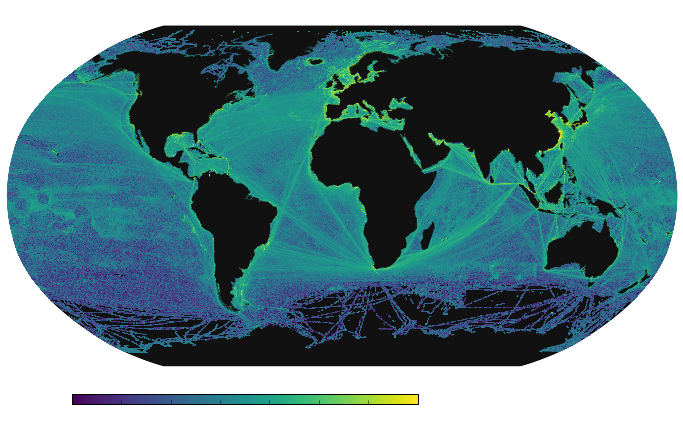

In [46]:
plt.rcParams["figure.figsize"] = [12,7]

cutoff = 5 # 5 degress away from the pole
firstlat = 90-cutoff
lastlat = -90+cutoff
firstlon = -180
lastlon = 180
scale = cellsize

vessel_days_truncated = vessel_days[one_over_cellsize*cutoff:(180*one_over_cellsize)-one_over_cellsize*cutoff][:]

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
          llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

m.drawmapboundary(fill_color='#111111')
# m.drawcoastlines(linewidth=.2)
m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

x = np.linspace(-180, 180, 360*one_over_cellsize)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = 10*100
minimum = .000001*100

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, vessel_days_truncated*100, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Density of Vessels with AIS"
plt.title(t, color = "#ffffff", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

the_labels = []
for l in lvls:
    if l>=1:
        l = int(l)
    the_labels.append(l)

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
cb.set_label('Average Number of Vessels per 10,000 km$\mathregular{^2}$ in 2015',labelpad=-40, y=0.45, color = "#ffffff")

ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#ffffff', fontsize=6)

plt.savefig("vessel_density_2015.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
plt.show()
